In [33]:
import os, json, joblib
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import matplotlib.pyplot as plt



## Config


In [34]:

CSV_PATH = "merged_combats_v2.csv"
TARGET_COL = "Is_First_Pokemon_Win"

PCA_N_COMPONENTS = 9

DROP_COLS = [
    "First_pokemon","Second_pokemon","Winner","Name_1","Name_2",
    "Type_1_1","Type_1_2","Type_2_1","Type_2_2",
    "Generation_1","Generation_2","Legendary_1","Legendary_2",
    "HP_1","Attack_1","Defense_1","Sp_Atk_1","Sp_Def_1","Speed_1",
    "HP_2","Attack_2","Defense_2","Sp_Atk_2","Sp_Def_2","Speed_2",
]



## Data Prep


In [35]:
class DataPrepTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_columns=None):
        self.drop_columns = drop_columns or []
        self.feature_columns_ = []

    def fit(self, X: pd.DataFrame, y=None):
        Xt = self.transform(X.copy())
        self.feature_columns_ = list(Xt.columns)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()

        for side in ("1", "2"):
            df[f"BST_{side}"] = (
                df[f"HP_{side}"].astype(float)
                + df[f"Attack_{side}"].astype(float)
                + df[f"Defense_{side}"].astype(float)
                + df[f"Sp_Atk_{side}"].astype(float)
                + df[f"Sp_Def_{side}"].astype(float)
                + df[f"Speed_{side}"].astype(float)
            )
        df["BST_diff"]  = df["BST_1"] - df["BST_2"]

        df = df.drop(columns=self.drop_columns, errors='ignore')

        return df


## Data load


In [36]:

df = pd.read_csv(CSV_PATH)

df = df.drop_duplicates()
df = df.dropna()

y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
)

print(df.head())

   First_pokemon  Second_pokemon  Winner    Name_1 Type_1_1  Type_2_1  HP_1  \
0            266             298     298  Larvitar     Rock    Ground    50   
1            702             701     701  Virizion    Grass  Fighting    91   
4            151             231     151   Omastar     Rock     Water    70   
5            657             752     657    Joltik      Bug  Electric    50   
6            192             134     134      Natu  Psychic    Flying    40   

   Attack_1  Defense_1  Sp_Atk_1  ...  Legendary_2  Is_First_Pokemon_Win  \
0        64         50        45  ...        False                     0   
1        90         72        90  ...         True                     0   
4        60        125       115  ...        False                     1   
5        47         50        57  ...        False                     1   
6        50         45        70  ...        False                     0   

   HP_diff  Attack_diff Defense_diff Sp_Atk_diff Sp_Def_diff  Speed_


## Pipeline with PCA


In [46]:

n_comp = PCA_N_COMPONENTS

pipeline = Pipeline(steps=[
    ("prep", DataPrepTransformer(drop_columns=DROP_COLS)),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=n_comp, random_state=0)),
    ("model", RandomForestClassifier(n_estimators=100, max_features=2, random_state=42)),
])

pipeline


Pipeline(steps=[('prep',
                 DataPrepTransformer(drop_columns=['First_pokemon',
                                                   'Second_pokemon', 'Winner',
                                                   'Name_1', 'Name_2',
                                                   'Type_1_1', 'Type_1_2',
                                                   'Type_2_1', 'Type_2_2',
                                                   'Generation_1',
                                                   'Generation_2',
                                                   'Legendary_1', 'Legendary_2',
                                                   'HP_1', 'Attack_1',
                                                   'Defense_1', 'Sp_Atk_1',
                                                   'Sp_Def_1', 'Speed_1',
                                                   'HP_2', 'Attack_2',
                                                   'Defense_2', 'Sp_Atk_2',
                                                   'Sp_Def_2', 'Speed_2'])),
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=9, random_state=0)),
                ('model',
                 RandomForestClassifier(max_features=2, random_state=42))])


## Pipeline without PCA


In [50]:

n_comp = PCA_N_COMPONENTS

pipeline = Pipeline(steps=[
    ("prep",   DataPrepTransformer(drop_columns=DROP_COLS)),
    ("scaler", StandardScaler()),
    ("model",  RandomForestClassifier(n_estimators=100, max_features=2, random_state=0)),
])

pipeline


Pipeline(steps=[('prep',
                 DataPrepTransformer(drop_columns=['First_pokemon',
                                                   'Second_pokemon', 'Winner',
                                                   'Name_1', 'Name_2',
                                                   'Type_1_1', 'Type_1_2',
                                                   'Type_2_1', 'Type_2_2',
                                                   'Generation_1',
                                                   'Generation_2',
                                                   'Legendary_1', 'Legendary_2',
                                                   'HP_1', 'Attack_1',
                                                   'Defense_1', 'Sp_Atk_1',
                                                   'Sp_Def_1', 'Speed_1',
                                                   'HP_2', 'Attack_2',
                                                   'Defense_2', 'Sp_Atk_2',
                                                   'Sp_Def_2', 'Speed_2'])),
                ('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_features=2, random_state=0))])


## Train & report




Accuracy test (%): 93.82


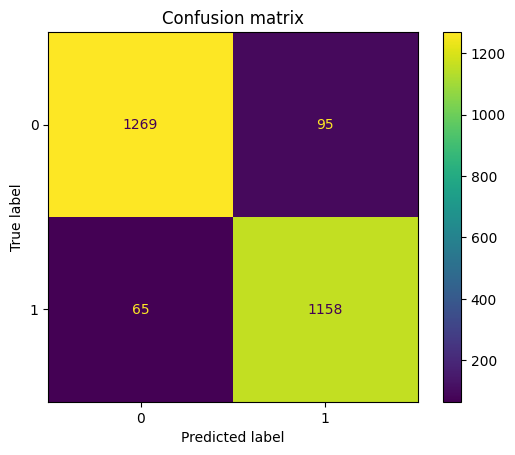

In [51]:

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm  = confusion_matrix(y_test, y_pred)

print(f"Accuracy test (%): {acc*100:.2f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion matrix")
plt.show()


In [52]:
model = pipeline.named_steps["model"]
prep = pipeline.named_steps["prep"]

feature_names = prep.feature_columns_
importances = model.feature_importances_

for name, imp in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {imp:.4f}")


Speed_diff: 0.5869
BST_diff: 0.0916
Attack_diff: 0.0502
BST_1: 0.0472
Sp_Atk_diff: 0.0452
Defense_diff: 0.0442
BST_2: 0.0430
HP_diff: 0.0361
Sp_Def_diff: 0.0311
Type_Effectiveness_1: 0.0134
Type_Effectiveness_2: 0.0111


## Save pipeline


In [53]:
joblib.dump(pipeline, "pokemon_pipeline.pkl")

['pokemon_pipeline.pkl']

## Grid Search to find best pca n_components


n_components= 2 → acc=0.6853
n_components= 3 → acc=0.7940
n_components= 4 → acc=0.8013
n_components= 5 → acc=0.8048
n_components= 6 → acc=0.8040
n_components= 7 → acc=0.8454
n_components= 8 → acc=0.8724
n_components= 9 → acc=0.8782
n_components=10 → acc=0.8763
n_components=11 → acc=0.8775
Best n_components: 9 acc: 0.8782373405488983


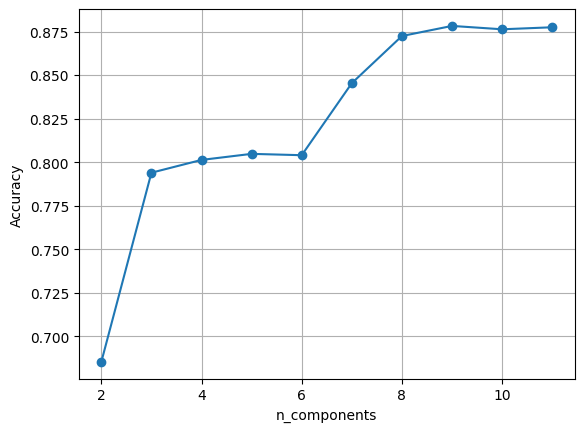

In [39]:

def grid_search_pca_n_components(X_train, y_train, X_test, y_test, n_min=2, n_max_override=None):
    temp_pipeline = Pipeline([
        ("prep",   DataPrepTransformer(drop_columns=DROP_COLS)),
        ("scaler", StandardScaler()),
    ])
    X_train_preprocessed = temp_pipeline.fit_transform(X_train, y_train)
    actual_n_features = X_train_preprocessed.shape[1]

    if n_max_override is None:
        n_max_pca = actual_n_features
    else:
        n_max_pca = min(n_max_override, actual_n_features)

    best_acc, best_n, best_pipe = -1.0, None, None
    results = {}

    for n in range(n_min, n_max_pca + 1):
        pipe = Pipeline([
            ("prep",   DataPrepTransformer(drop_columns=DROP_COLS)),
            ("scaler", StandardScaler()),
            ("pca",    PCA(n_components=n, random_state=42)),
            ("model",  RandomForestClassifier(n_estimators=300, random_state=42)),
        ])
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        acc = accuracy_score(y_test, preds)
        results[n] = acc
        print(f"n_components={n:2d} → acc={acc:.4f}")
        if acc > best_acc:
            best_acc, best_n, best_pipe = acc, n, pipe

    return best_pipe, best_n, results

best_pipe, best_n, results = grid_search_pca_n_components(X_train, y_train, X_test, y_test, n_min=2)
print("Best n_components:", best_n, "acc:", results[best_n])
xs = sorted(results.keys()); ys = [results[k] for k in xs]
plt.plot(xs, ys, marker="o"); plt.xlabel("n_components"); plt.ylabel("Accuracy"); plt.grid(True); plt.show()
